# IoT Security
Network Intrusion Detection dataset

# Machine Learning and deep learning models for network intrusion detection

# Step 1: Data Collection (downloading)

For this use case we are using famus opensource KDDCUP99 data. Please go to this link http://kdd.ics.uci.edu/databases/kddcup99/ and download kddcup.data_10_percent.gz dataset, and save into your preferred folder for further use.

# Step 2: Pre-processing

# Splitting of the Dataset

In [1]:
#Load the Entire Data

#Importing all the required Libraries

import pandas as pd

IDSdata = pd.read_csv("cupdata/kddcup.data_10_percent.csv",header = None,engine = 'python',sep=",")

# Add column header 

IDSdata.columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragement",
                   "urgent",
                  "hot","num_failed_logins","logged_in","num_compressed","root_shell","su_attempted","num_root",
                   "num_file_creations",
                  "num_shells","num_access_files","num_outbound_cmds","is_hot_login","is_guest_login","count","srv_count","serror_rate",
                  "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate",
                   "srv_diff_host_rate","dst_host_count",
                  "dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
                   "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
                  "dst_host_srv_rerror_rate","labels"]

# Explore the Application Layer IDS Data

ApplicationLayer = IDSdata[(IDSdata['labels'].isin(['normal.','smurf.','back.','satan.','pod.','guess_passwd.','buffer_overflow.',
                                                    'warezmaster.','imap.','loadmodule.','ftp_write.','multihop.','perl.']))]
print (ApplicationLayer['labels'].value_counts())

# Save a Applayer data only into a text file
ApplicationLayer.to_csv('Final_App_Layer.txt',header = None,index = False)

# Explore the Transport Layer IDS Data
TransportLayer = IDSdata[(IDSdata['labels'].isin(['normal.','neptune.','portsweep.','teardrop.','buffer_overflow.',
                                                 'land.','nmap.']))]
print (TransportLayer['labels'].value_counts())
TransportLayer.to_csv('Final_Transport_Layer.txt',header = None,index = False)

# Explore the Network Layer IDS Data
NetworkLayer = IDSdata[(IDSdata['labels'].isin(['normal.','smurf.','ipsweep.','pod.','buffer_overflow.']))]
print (NetworkLayer['labels'].value_counts())
NetworkLayer.to_csv('Final_Network_Layer.txt',header = None,index = False)


smurf.              280790
normal.              97278
back.                 2203
satan.                1589
pod.                   264
guess_passwd.           53
buffer_overflow.        30
warezmaster.            20
imap.                   12
loadmodule.              9
ftp_write.               8
multihop.                7
perl.                    3
Name: labels, dtype: int64
neptune.            107201
normal.              97278
portsweep.            1040
teardrop.              979
nmap.                  231
buffer_overflow.        30
land.                   21
Name: labels, dtype: int64
smurf.              280790
normal.              97278
ipsweep.              1247
pod.                   264
buffer_overflow.        30
Name: labels, dtype: int64


# Duplicate data removal, categorical data conversion and normalisation

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import matplotlib.pylab as plt


## For OMP error
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Functions for DataLoading and pre-processing

def DataLoading (mypath):
    print ("Loading the data")
    dataframe = pd.read_csv(mypath,header = None,engine = 'python',sep=",")
    return dataframe

def DataPreprocessing(mydataframe):
    
    # Dropping the duplicates
    recordcount = len(mydataframe)
    print ("Original number of records in the training dataset before removing duplicates is: " , recordcount)
    mydataframe.drop_duplicates(subset=None, inplace=True)  # Python command to drop duplicates
    newrecordcount = len(mydataframe)
    print ("Number of records in the training dataset after removing the duplicates is :", newrecordcount,"\n")

    #Dropping the labels to a different dataset which is used to train the recurrent neural network classifier
    df_X = mydataframe.drop(mydataframe.columns[41],axis=1,inplace = False)
    df_Y = mydataframe.drop(mydataframe.columns[0:41],axis=1, inplace = False)

    # Convert Categorial data to the numerical data for the efficient classification
    df_X[df_X.columns[1:4]] = df_X[df_X.columns[1:4]].stack().rank(method='dense').unstack()
    
    # Coding the normal as " 1 0" and attack as "0 1"
    df_Y[df_Y[41]!='normal.'] = 0
    df_Y[df_Y[41]=='normal.'] = 1
    #print (labels[41].value_counts())
    
    #converting input data into float which is requried in the future stage of building in the network
    df_X = df_X.loc[:,df_X.columns[0:41]].astype(float)

    # Normal is "1 0" and the abnormal is "0 1"
    df_Y.columns = ["y1"]
    df_Y.loc[:,('y2')] = df_Y['y1'] ==0
    df_Y.loc[:,('y2')] = df_Y['y2'].astype(int)
    
    return df_X,df_Y

print ("Laoding the IDS Data")
#data_path = "Final_App_Layer.txt" # If you want to use for Applicaiton Layer
#data_path = "Final_Transport_Layer.txt" # If you want to use for Transport Layer
data_path = "Final_Network_Layer.txt" # If you want to use for Network Layer

dataframe = DataLoading(data_path)

print ("Data Preprocessing of loaded IDS Data")
data_X, data_Y = DataPreprocessing(dataframe)

Laoding the IDS Data
Loading the data
Data Preprocessing of loaded IDS Data
Original number of records in the training dataset before removing duplicates is:  379609
Number of records in the training dataset after removing the duplicates is : 89360 



# Feature selection (optional pre-processing, but useful for network size)

Performing the Feature Selection on the train data set


C:\Users\moona\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


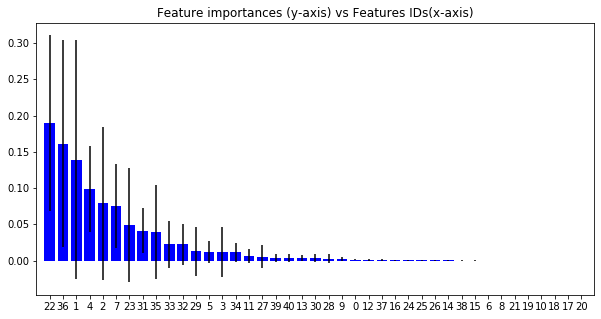

C:\Users\moona\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [3]:
##### Function for features selection for the Model Training

def FeatureSelection(myinputX, myinputY):

    labels = np.array(myinputY).astype(int)
    inputX = np.array(myinputX)
    
    #Random Forest Model
    model = RandomForestClassifier(random_state = 0)
    model.fit(inputX,labels)
    importances = model.feature_importances_
    
    
    #Plotting the Features agains their importance scores
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
    plt.figure(figsize = (10,5))
    plt.title("Feature importances (y-axis) vs Features IDs(x-axis)")
    plt.bar(range(inputX.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
    plt.xticks(range(inputX.shape[1]), indices)
    plt.xlim([-1, inputX.shape[1]])
    plt.show()
    
    # Selecting top featueres which have higher importance values = here we can find "12" features
    #as we can see in the next step
    newX = myinputX.iloc[:,model.feature_importances_.argsort()[::-1][:12]]
   # Converting the X dataframe into tensors
    myX = newX.as_matrix()
    myY = labels

    return myX,myY

## Visualise the data for feature selction
    

print ("Performing the Feature Selection on the train data set")
reduced_X,reduced_Y = FeatureSelection(data_X,data_Y)


In [4]:
reduced_X.shape

(89360, 12)

In [5]:
reduced_Y.shape

(89360, 2)

In [9]:
#y=one_hot2indices(Y)
#y=np.where(Y[0]==1)
Y=[np.where(r==1)[0][0] for r in reduced_Y]

In [11]:
Y=np.array(Y)

In [12]:
Y.shape

(89360,)

In [13]:
Y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [14]:
X=reduced_X
y=Y

In [15]:
X.shape

(89360, 12)

In [16]:
y.shape

(89360,)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)

In [20]:
print ("Train X shape is :", X_train.shape)
print ("Train Y shape is :", y_train.shape)
print ("Test X shape is :", X_test.shape)
print ("Test Y shape is :", y_test.shape)

Train X shape is : (80424, 12)
Train Y shape is : (80424,)
Test X shape is : (8936, 12)
Test Y shape is : (8936,)


# Machine Learning models for network intrusion dtection

C:\Users\moona\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\moona\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


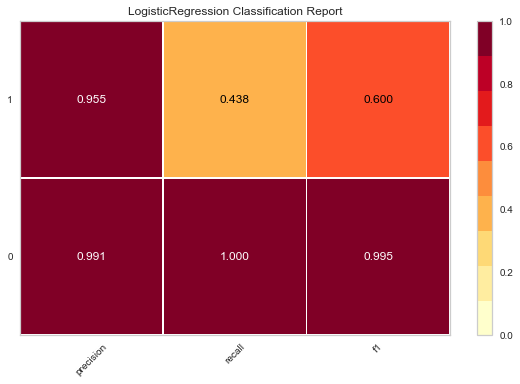

In [21]:
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression
viz = ClassificationReport(LogisticRegression())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

C:\Users\moona\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


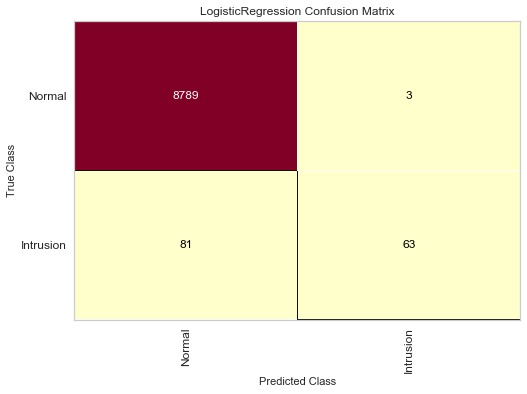

In [22]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ConfusionMatrix

classes = ["Normal","Intrusion"]

model = LogisticRegression(multi_class="auto", solver="liblinear")

m_cm = ConfusionMatrix(
    model, classes=classes,
    label_encoder={0: 'Normal', 1: 'Intrusion'}
)

m_cm.fit(X_train, y_train)
m_cm.score(X_test, y_test)

m_cm.poof()

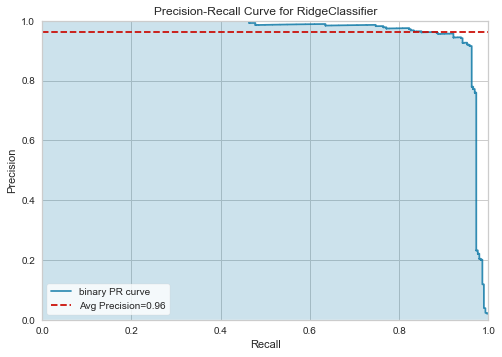

In [23]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split as tts
from yellowbrick.classifier import PrecisionRecallCurve
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, shuffle=True)

# Create the visualizer, fit, score, and poof it
viz = PrecisionRecallCurve(RidgeClassifier())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

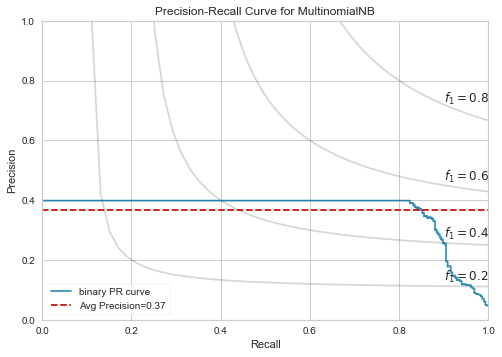

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split as tts
from yellowbrick.classifier import PrecisionRecallCurve

X = OrdinalEncoder().fit_transform(X)
encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, shuffle=True)

# Create the visualizer, fit, score, and poof it
viz = PrecisionRecallCurve(
    MultinomialNB(), per_class=True, iso_f1_curves=True,
    fill_area=False, micro=False, classes=encoder.classes_
)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

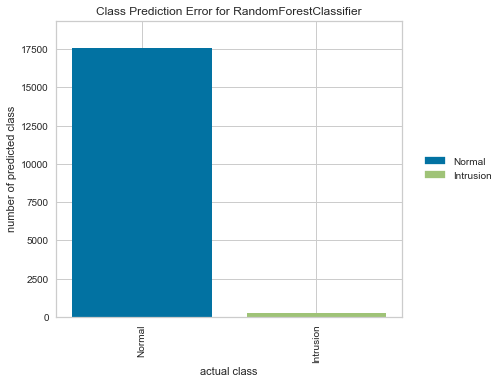

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassPredictionError

classes = ["Normal","Intrusion"]

# Perform 80/20 training/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=42)

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    RandomForestClassifier(n_estimators=10), classes=classes
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.poof()

# Deep Learning model for network intrsuion detection

# Step 3: Model Training and Validation

In [4]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l1
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.models import load_model

# Train features and Train Labels
train_X = reduced_X[:8000]
train_Y = reduced_Y[:8000]

#Test Features and Test Labels
test_X = reduced_X[8001:10000]
test_Y = reduced_Y[8001:10000]


print ("Train X shape is :", train_X.shape)
print ("Train Y shape is :", train_Y.shape)
print ("Test X shape is :", test_X.shape)
print ("Test Y shape is :", test_Y.shape)

## Normalizing the Input Features: Using tensorflow normalizing function

# Before normalizing, the array of input features should be converted to a dataframe
semitrain_X = pd.DataFrame(train_X)
semitest_X = pd.DataFrame(test_X)
#Importing Scikit learn libraries
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#Normalizing Train Data Features
scaler_traindata = scaler.fit(semitrain_X)
train_norm = scaler_traindata.transform(semitrain_X)
X_train=train_norm_X = pd.DataFrame(train_norm)

#Normalizing Test Data Features
scaler_testdata = scaler.fit(semitest_X)
test_norm = scaler_testdata.transform(semitest_X)
X_test=test_norm_X = pd.DataFrame(test_norm)
#Testing/Training Data
Y_train=train_Y
Y_test=test_Y
# Useful paprameters for the Autoencoder
 # dimension one one input data
input_dim = X_train.shape[1]
# this is the size of our encoded representations
encoding_dim = 32 
    
## For OMP error
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim), activation="relu")(encoder)
encoder = Dense(int(encoding_dim-2), activation="relu")(encoder)
code = Dense(int(encoding_dim-4), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim-2), activation='tanh')(code)
decoder = Dense(int(encoding_dim), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

## Parameters for Model configuration and saving 
nb_epoch = 100
batch_size = 60
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
                               
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history
                                                

autoencoder = load_model('model.h5')
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

Using TensorFlow backend.


Train X shape is : (8000, 12)
Train Y shape is : (8000, 2)
Test X shape is : (1999, 12)
Test Y shape is : (1999, 2)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 8000 samples, validate on 1999 samples
Epoch 1/100
8000/8000 [==============================] - 2s 262us/step - loss: 0.1640 - acc: 0.4454 - val_loss: 0.1481 - val_acc: 0.8939
Epoch 2/100
8000/8000 [==============================] - 1s 81us/step - loss: 0.0901 - acc: 0.7556 - val_loss: 0.1449 - val_acc: 0.6353
Epoch 3/100
8000/8000 [==============================] - 1s 107us/step - loss: 0.0835 - acc: 0.7321 - val_loss: 0.1356 - val_acc: 0.7109
Epoch 4/100
8000/8000 [==============================] - 1s 93us/step - loss: 0.0811 - acc: 0.7331 - val_loss: 0.1286 - val_acc: 0.9475
Epoch 5/100
8000/8000 [==============================] - 1s 84us/step - loss: 0.0802 - acc: 0.7672 - val_loss: 0.1306 - val_acc: 0.9160
Epoch 6/100
8000/8000 [===========